In [1]:
import mne
import os
import numpy as np


In [2]:
# Change to the directory containing the BrainVision files
os.chdir('/home/st/st_us-053000/st_st190561/EEG')

# Verify the current directory
print(os.getcwd())

/pfs/data5/home/st/st_us-053000/st_st190561/EEG


In [14]:
import mne
import os
import numpy as np
from pathlib import Path
from mne_bids import BIDSPath, read_raw_bids
from mne.preprocessing import ICA
from mne_icalabel import label_components

# Define paths and parameters
bids_root = "/home/st/st_us-053000/st_st190561/EEG"
session_id = "Vibro"
output_directory = "/home/st/st_us-053000/st_st190561/EEG/ica/Vibro"

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Iterate over subjects (sub-02 to sub-20)
for i in range(2, 21):  # Start from 2 and end at 20
    subject_id = f"{i:02}"  # Format as zero-padded, e.g., "02", "03", ..., "20"

    # Construct BIDSPath for the subject
    bids_path = BIDSPath(
        subject=subject_id,
        session=session_id,
        task="PredictionError",
        datatype="eeg",
        suffix="eeg",
        root=bids_root,
    )
    
    try:
        # Read the raw EEG data
        raw = read_raw_bids(bids_path)
        raw.load_data()
        
        # Print the BIDS path to verify it
        print("Successfully processed:", bids_path)
        raw.rename_channels({name: name.replace('BrainVision RDA_', '') for name in raw.ch_names})
        raw.annotations.onset = raw.annotations.onset - 0.063
        raw_resampled = raw.copy().resample(sfreq=250, npad="auto")
        filtered = raw_resampled.copy().filter(l_freq=1.0, h_freq=124.0)
        raw_filtered = filtered.copy().notch_filter(freqs=50.0)
        raw_referenced = raw_filtered.set_eeg_reference(ref_channels=['Fz', 'FC1', 'FC2', 'Cz'], ch_type='eeg')
        raw_filtered.set_montage('standard_1020', match_case=False)
        from mne.preprocessing import ICA
        events, event_id = mne.events_from_annotations(raw_filtered)
        epochs = mne.Epochs(raw_filtered, events, event_id, tmin=-0.3, tmax=0.7, 
                    preload=True, event_repeated="drop")

        # Compute Mean Absolute Amplitude for Each Epoch
        epoch_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
        mean_amplitudes = np.mean(np.abs(epoch_data), axis=(1, 2))  # Mean over channels and time

        # Rank Epochs by Mean Amplitude
        ranked_indices = np.argsort(mean_amplitudes)  # Sort epochs from smallest to largest mean amplitude

        # Keep 85% of the Cleanest Epochs
        percentage = 85
        n_epochs_to_keep = int(len(epochs) * (percentage / 100))
        selected_indices = ranked_indices[:n_epochs_to_keep]  # Select top 85% clean epochs

        # Create Clean Epochs and Apply ICA
        clean_epochs = epochs[selected_indices]

        ica = ICA(n_components=10, method='picard', random_state=42, max_iter=5000)
        ica.fit(clean_epochs)
        labels = label_components(raw_filtered, ica, method='iclabel')

        print("ICLabel Results:")
        for idx, (label, prob) in enumerate(zip(labels['labels'], labels['y_pred_proba'])):
            print(f"Component {idx}: {label} (Probability: {prob:.2f})")

        # Automatically mark bad components for exclusion
        bad_ics = [idx for idx, label in enumerate(labels['labels'])
                if label in ('eye blink', 'muscle artifact', 'line_noise')]

        ica.exclude = bad_ics  # Mark components for exclusion

        ica.apply(raw_filtered)

        raw_filtered.set_meas_date(None)
       
        output_file = os.path.join(output_directory, f"sub-{subject_id}_processed.fif")

        raw_filtered.save(output_file, overwrite=True)

    
    except Exception as e:
        print(f"Error processing {bids_path}: {e}")


Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-02/ses-Vibro/eeg/sub-02_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-02/ses-Vibro/eeg/sub-02_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-02/ses-Vibro/eeg/sub-02_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 838759  =      0.000 ...  1677.540 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 58
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-02/ses-Vibro/eeg/sub-02_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.208381'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.771618'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.770561'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.683931'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.005351'), np.str_('box:spawned;condition:vi

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 6.4s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: eye blink (Probability: 1.00)
Component 1: eye blink (Probability: 1.00)
Component 2: brain (Probability: 1.00)
Component 3: brain (Probability: 0.99)
Component 4: channel noise (Probability: 0.90)
Component 5: brain (Probability: 0.99)
Component 6: brain (Probability: 0.66)
Component 7: brain (Probability: 0.58)
Component 8: muscle artifact (Probability: 0.76)
Component 9: brain (Probability: 0.96)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 3 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-02_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-02_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-02_processed.fif
[done]
Error processing /home/st/st_us-053000/st_st190561/EEG/sub-03/ses-Vibro/eeg/sub-03_ses-Vibro_task-PredictionError_eeg: [Errno 2] No such file or directory: '/home/st/st_us-053000/st_st190561/EEG/sub-03/ses-Vibro/eeg'
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-04/ses-Vibro/eeg/sub-04_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-04/ses-Vibro/eeg/sub-04_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-04/ses-Vibro/eeg/sub-04_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 992919  =      0.000 ...  1985.875 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 60
block_1: Visual
block_2: Visual + Vibro
block_3: 0
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-04/ses-Vibro/eeg/sub-04_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeRight (UnityEngine.GameObject);isiTime:1.112771'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.653742'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.054914'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.731717'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeRight (Unity

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 17.1s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: brain (Probability: 1.00)
Component 1: eye blink (Probability: 0.81)
Component 2: eye blink (Probability: 1.00)
Component 3: brain (Probability: 0.97)
Component 4: brain (Probability: 1.00)
Component 5: brain (Probability: 0.99)
Component 6: muscle artifact (Probability: 0.96)
Component 7: muscle artifact (Probability: 0.94)
Component 8: muscle artifact (Probability: 0.99)
Component 9: muscle artifact (Probability: 0.99)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 6 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-04_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-04_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-04_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-05/ses-Vibro/eeg/sub-05_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-05/ses-Vibro/eeg/sub-05_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-05/ses-Vibro/eeg/sub-05_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 924459  =      0.000 ...  1848.942 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 58
block_1: Visual + Vibro
block_2: Visual
block_3: 0
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-05/ses-Vibro/eeg/sub-05_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.144351'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.44099'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.263126'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.066'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeMiddle (UnityEng

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 6.0s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: brain (Probability: 0.96)
Component 1: eye blink (Probability: 1.00)
Component 2: eye blink (Probability: 1.00)
Component 3: brain (Probability: 0.94)
Component 4: brain (Probability: 1.00)
Component 5: brain (Probability: 0.96)
Component 6: muscle artifact (Probability: 1.00)
Component 7: brain (Probability: 0.98)
Component 8: muscle artifact (Probability: 0.43)
Component 9: muscle artifact (Probability: 0.95)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 5 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-05_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-05_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-05_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-06/ses-Vibro/eeg/sub-06_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-06/ses-Vibro/eeg/sub-06_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-06/ses-Vibro/eeg/sub-06_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 932969  =      0.000 ...  1865.967 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 55
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-06/ses-Vibro/eeg/sub-06_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeRight (UnityEngine.GameObject);isiTime:1.502973'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.227769'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.380926'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:conflict;cube:CubeRight (UnityEngine.GameObject);isiTime:1.254071'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeMiddle (Unit

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 6.7s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: brain (Probability: 0.56)
Component 1: eye blink (Probability: 0.99)
Component 2: eye blink (Probability: 0.65)
Component 3: brain (Probability: 0.70)
Component 4: brain (Probability: 0.83)
Component 5: brain (Probability: 1.00)
Component 6: brain (Probability: 0.40)
Component 7: muscle artifact (Probability: 0.93)
Component 8: brain (Probability: 0.85)
Component 9: muscle artifact (Probability: 0.86)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 4 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-06_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-06_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-06_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-07/ses-Vibro/eeg/sub-07_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-07/ses-Vibro/eeg/sub-07_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-07/ses-Vibro/eeg/sub-07_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 1009159  =      0.000 ...  2018.341 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 54
block_1: Visual + Vibro
block_2: Visual
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-07/ses-Vibro/eeg/sub-07_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeRight (UnityEngine.GameObject);isiTime:1.127061'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.128906'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:conflict;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.530674'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.835503'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeRight (Unity

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 9.8s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: eye blink (Probability: 0.99)
Component 1: brain (Probability: 0.99)
Component 2: eye blink (Probability: 1.00)
Component 3: brain (Probability: 0.93)
Component 4: brain (Probability: 0.38)
Component 5: brain (Probability: 1.00)
Component 6: muscle artifact (Probability: 0.69)
Component 7: brain (Probability: 0.76)
Component 8: muscle artifact (Probability: 0.71)
Component 9: other (Probability: 0.88)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 4 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-07_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-07_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-07_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-08/ses-Vibro/eeg/sub-08_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-08/ses-Vibro/eeg/sub-08_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-08/ses-Vibro/eeg/sub-08_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 1192509  =      0.000 ...  2385.057 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 58
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-08/ses-Vibro/eeg/sub-08_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.944103'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.23711'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.494148'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.946908'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeRight (UnityEng

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 5.0s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: other (Probability: 0.47)
Component 1: muscle artifact (Probability: 0.45)
Component 2: other (Probability: 0.59)
Component 3: eye blink (Probability: 0.98)
Component 4: eye blink (Probability: 0.99)
Component 5: brain (Probability: 0.99)
Component 6: brain (Probability: 0.99)
Component 7: brain (Probability: 1.00)
Component 8: muscle artifact (Probability: 0.83)
Component 9: muscle artifact (Probability: 0.46)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 5 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-08_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-08_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-08_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-09/ses-Vibro/eeg/sub-09_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-09/ses-Vibro/eeg/sub-09_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-09/ses-Vibro/eeg/sub-09_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 1062589  =      0.000 ...  2125.203 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 54
block_1: Visual + Vibro
block_2: Visual
block_3: 0
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-09/ses-Vibro/eeg/sub-09_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.715798'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.49396'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.466945'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.371052'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:conflict;cube:CubeMiddle (Uni

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 4.9s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: eye blink (Probability: 1.00)
Component 1: eye blink (Probability: 1.00)
Component 2: brain (Probability: 0.84)
Component 3: muscle artifact (Probability: 1.00)
Component 4: muscle artifact (Probability: 0.98)
Component 5: muscle artifact (Probability: 0.89)
Component 6: muscle artifact (Probability: 0.83)
Component 7: muscle artifact (Probability: 1.00)
Component 8: muscle artifact (Probability: 0.99)
Component 9: muscle artifact (Probability: 0.86)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 9 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-09_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-09_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-09_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-10/ses-Vibro/eeg/sub-10_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-10/ses-Vibro/eeg/sub-10_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-10/ses-Vibro/eeg/sub-10_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 1124109  =      0.000 ...  2248.261 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 54
block_1: Visual
block_2: Visual + Vibro
block_3: 0
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-10/ses-Vibro/eeg/sub-10_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.616514'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.935518'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.646738'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.125946'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeMiddle (Unity

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 7.5s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: other (Probability: 0.55)
Component 1: brain (Probability: 0.79)
Component 2: muscle artifact (Probability: 0.76)
Component 3: brain (Probability: 0.93)
Component 4: eye blink (Probability: 0.98)
Component 5: eye blink (Probability: 0.94)
Component 6: muscle artifact (Probability: 0.38)
Component 7: other (Probability: 0.57)
Component 8: muscle artifact (Probability: 0.98)
Component 9: channel noise (Probability: 0.32)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 5 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-10_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-10_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-10_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-11/ses-Vibro/eeg/sub-11_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-11/ses-Vibro/eeg/sub-11_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-11/ses-Vibro/eeg/sub-11_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 1033049  =      0.000 ...  2066.138 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 56
block_1: Visual + Vibro
block_2: Visual
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-11/ses-Vibro/eeg/sub-11_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.288791'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.857156'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.265386'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.025477'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeRight (Unit

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 6.3s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: brain (Probability: 0.98)
Component 1: eye blink (Probability: 1.00)
Component 2: eye blink (Probability: 1.00)
Component 3: muscle artifact (Probability: 0.98)
Component 4: brain (Probability: 1.00)
Component 5: muscle artifact (Probability: 0.91)
Component 6: brain (Probability: 1.00)
Component 7: brain (Probability: 1.00)
Component 8: brain (Probability: 0.61)
Component 9: other (Probability: 0.57)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 4 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-11_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-11_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-11_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-12/ses-Vibro/eeg/sub-12_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-12/ses-Vibro/eeg/sub-12_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-12/ses-Vibro/eeg/sub-12_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 966119  =      0.000 ...  1932.264 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 54
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-12/ses-Vibro/eeg/sub-12_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.648459'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.817742'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.490776'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.857903'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeLeft (UnityEn

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 9.8s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: brain (Probability: 0.84)
Component 1: brain (Probability: 0.85)
Component 2: eye blink (Probability: 1.00)
Component 3: eye blink (Probability: 0.99)
Component 4: muscle artifact (Probability: 0.66)
Component 5: muscle artifact (Probability: 1.00)
Component 6: muscle artifact (Probability: 1.00)
Component 7: brain (Probability: 0.99)
Component 8: muscle artifact (Probability: 1.00)
Component 9: brain (Probability: 1.00)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 6 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-12_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-12_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-12_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-13/ses-Vibro/eeg/sub-13_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-13/ses-Vibro/eeg/sub-13_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-13/ses-Vibro/eeg/sub-13_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 1019259  =      0.000 ...  2038.552 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 54
block_1: Visual + Vibro
block_2: Visual
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-13/ses-Vibro/eeg/sub-13_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.643676'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.179683'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.899021'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.331825'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:conflict;cube:CubeMiddle (Un

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 4.6s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: channel noise (Probability: 0.64)
Component 1: eye blink (Probability: 0.95)
Component 2: eye blink (Probability: 0.87)
Component 3: brain (Probability: 1.00)
Component 4: brain (Probability: 0.81)
Component 5: brain (Probability: 0.77)
Component 6: brain (Probability: 0.46)
Component 7: muscle artifact (Probability: 1.00)
Component 8: muscle artifact (Probability: 0.77)
Component 9: muscle artifact (Probability: 0.91)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 5 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-13_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-13_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-13_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-14/ses-Vibro/eeg/sub-14_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-14/ses-Vibro/eeg/sub-14_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-14/ses-Vibro/eeg/sub-14_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 1043939  =      0.000 ...  2087.908 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 54
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-14/ses-Vibro/eeg/sub-14_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.974575'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.702427'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:conflict;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.704911'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.171111'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeRight (Unity

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 5.8s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: muscle artifact (Probability: 0.97)
Component 1: eye blink (Probability: 1.00)
Component 2: eye blink (Probability: 0.91)
Component 3: brain (Probability: 0.73)
Component 4: brain (Probability: 0.91)
Component 5: muscle artifact (Probability: 1.00)
Component 6: muscle artifact (Probability: 1.00)
Component 7: brain (Probability: 0.92)
Component 8: brain (Probability: 0.85)
Component 9: muscle artifact (Probability: 0.66)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 6 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-14_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-14_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-14_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-15/ses-Vibro/eeg/sub-15_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-15/ses-Vibro/eeg/sub-15_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-15/ses-Vibro/eeg/sub-15_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 1048349  =      0.000 ...  2096.734 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 54
block_1: Visual + Vibro
block_2: Visual
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-15/ses-Vibro/eeg/sub-15_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeRight (UnityEngine.GameObject);isiTime:1.617197'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.898567'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.295485'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.014'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeRight (UnityEn

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 4.9s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: eye blink (Probability: 1.00)
Component 1: eye blink (Probability: 0.80)
Component 2: brain (Probability: 0.99)
Component 3: brain (Probability: 0.78)
Component 4: channel noise (Probability: 0.98)
Component 5: brain (Probability: 0.46)
Component 6: brain (Probability: 0.95)
Component 7: brain (Probability: 0.98)
Component 8: brain (Probability: 0.68)
Component 9: brain (Probability: 0.89)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-15_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-15_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-15_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-16/ses-Vibro/eeg/sub-16_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-16/ses-Vibro/eeg/sub-16_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-16/ses-Vibro/eeg/sub-16_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 881629  =      0.000 ...  1763.285 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 56
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-16/ses-Vibro/eeg/sub-16_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeRight (UnityEngine.GameObject);isiTime:1.893757'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.542798'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.07241'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.595718'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeRight (UnityEn

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 6.3s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: other (Probability: 0.53)
Component 1: other (Probability: 0.76)
Component 2: other (Probability: 0.33)
Component 3: other (Probability: 0.42)
Component 4: eye blink (Probability: 0.98)
Component 5: eye blink (Probability: 0.34)
Component 6: other (Probability: 0.38)
Component 7: muscle artifact (Probability: 0.59)
Component 8: brain (Probability: 0.73)
Component 9: muscle artifact (Probability: 0.83)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 4 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-16_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-16_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-16_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-17/ses-Vibro/eeg/sub-17_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-17/ses-Vibro/eeg/sub-17_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-17/ses-Vibro/eeg/sub-17_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 1127619  =      0.000 ...  2255.266 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 56
block_1: Visual + Vibro
block_2: Visual
block_3: 0
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-17/ses-Vibro/eeg/sub-17_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.555461'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.36921'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.106372'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:conflict;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.137226'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeMiddle (UnityEn

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 4.6s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: eye blink (Probability: 0.81)
Component 1: channel noise (Probability: 0.28)
Component 2: eye blink (Probability: 0.61)
Component 3: other (Probability: 0.40)
Component 4: other (Probability: 0.70)
Component 5: brain (Probability: 0.62)
Component 6: channel noise (Probability: 0.56)
Component 7: other (Probability: 0.39)
Component 8: muscle artifact (Probability: 0.86)
Component 9: other (Probability: 0.50)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 3 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-17_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-17_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-17_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-18/ses-Vibro/eeg/sub-18_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-18/ses-Vibro/eeg/sub-18_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-18/ses-Vibro/eeg/sub-18_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 912709  =      0.000 ...  1825.446 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 56
block_1: Visual
block_2: Visual + Vibro
block_3: 0
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-18/ses-Vibro/eeg/sub-18_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.22361'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.932299'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.668217'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:conflict;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.684711'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeMiddle (Unit

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 4.9s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: eye blink (Probability: 1.00)
Component 1: brain (Probability: 1.00)
Component 2: channel noise (Probability: 0.78)
Component 3: brain (Probability: 1.00)
Component 4: brain (Probability: 0.74)
Component 5: eye blink (Probability: 0.98)
Component 6: brain (Probability: 0.41)
Component 7: muscle artifact (Probability: 0.99)
Component 8: other (Probability: 0.48)
Component 9: brain (Probability: 0.56)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 3 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-18_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-18_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-18_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-19/ses-Vibro/eeg/sub-19_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-19/ses-Vibro/eeg/sub-19_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-19/ses-Vibro/eeg/sub-19_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 1044839  =      0.000 ...  2089.715 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 56
block_1: Visual + Vibro
block_2: Visual
block_3: 0
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-19/ses-Vibro/eeg/sub-19_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeRight (UnityEngine.GameObject);isiTime:1.965344'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.048706'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.132998'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:conflict;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.969775'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeRight (Unity

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 7.4s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: eye blink (Probability: 1.00)
Component 1: eye blink (Probability: 1.00)
Component 2: muscle artifact (Probability: 0.81)
Component 3: brain (Probability: 0.77)
Component 4: brain (Probability: 0.94)
Component 5: brain (Probability: 0.98)
Component 6: muscle artifact (Probability: 0.58)
Component 7: brain (Probability: 0.84)
Component 8: muscle artifact (Probability: 0.85)
Component 9: brain (Probability: 0.56)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 5 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-19_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-19_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-19_processed.fif
[done]
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-20/ses-Vibro/eeg/sub-20_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-20/ses-Vibro/eeg/sub-20_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-20/ses-Vibro/eeg/sub-20_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 910209  =      0.000 ...  1820.441 secs...


/scratch/ipykernel_812154/2516290139.py:33: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 54
block_1: Visual
block_2: Visual + Vibro
block_3: 0
  raw = read_raw_bids(bids_path)


Successfully processed: /home/st/st_us-053000/st_st190561/EEG/sub-20/ses-Vibro/eeg/sub-20_ses-Vibro_task-PredictionError_eeg.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.450401'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.076217'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:conflict;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.790175'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.213893'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeMiddle (Unit

/scratch/ipykernel_812154/2516290139.py:44: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


0 bad epochs dropped
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_812154/2516290139.py:66: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 4.8s.


/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_812154/2516290139.py:67: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: channel noise (Probability: 0.70)
Component 1: eye blink (Probability: 0.53)
Component 2: muscle artifact (Probability: 0.87)
Component 3: eye blink (Probability: 1.00)
Component 4: brain (Probability: 0.81)
Component 5: brain (Probability: 1.00)
Component 6: channel noise (Probability: 0.89)
Component 7: muscle artifact (Probability: 0.97)
Component 8: muscle artifact (Probability: 0.45)
Component 9: brain (Probability: 0.39)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 5 ICA components
    Projecting back using 63 PCA components
Writing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-20_processed.fif


/scratch/ipykernel_812154/2516290139.py:85: RuntimeWarning: This filename (/home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-20_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(output_file, overwrite=True)


Closing /home/st/st_us-053000/st_st190561/EEG/ica/Vibro/sub-20_processed.fif
[done]


In [34]:
file_path = "/home/st/st_us-053000/st_st190561/EEG/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_eeg.eeg"

print(os.path.exists(file_path))  # This should print True if the file exists
print(file_path)

True
/home/st/st_us-053000/st_st190561/EEG/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_eeg.eeg


In [2]:
# Load the data
from mne_bids import (BIDSPath,read_raw_bids)

# BIDS root directory
bids_root = "/home/st/st_us-053000/st_st190561/EEG"  # Update this if necessary

# Subject and session identifiers
subject_id = '02'  # Modify subject to use 'sub-01' instead of 'sub-1'
session_id = 'Visual'  # Session identifier (no change needed)

# Define the BIDS path for the EEG data (no extension, MNE will handle it automatically)
bids_path = BIDSPath(subject=subject_id, session=session_id,
                     task="PredictionError", datatype="eeg", suffix="eeg", root=bids_root)

raw = read_raw_bids(bids_path)

raw.load_data()


# Print the BIDS path to verify it
print("BIDS path:", bids_path)

/home/st/st_us-053000/st_st190561/EEG/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_eeg.vhdr
Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_channels.tsv.
Reading 0 ... 959079  =      0.000 ...  1918.184 secs...


/scratch/ipykernel_812154/2425790579.py:16: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 58
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


BIDS path: /home/st/st_us-053000/st_st190561/EEG/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_eeg.vhdr


In [36]:
# Strip 'BrainVision RDA_' from channel names
raw.rename_channels({name: name.replace('BrainVision RDA_', '') for name in raw.ch_names})


<RawBrainVision | sub-02_ses-Visual_task-PredictionError_eeg.eeg, 64 x 959080 (1918.2 s), ~468.4 MB, data loaded>

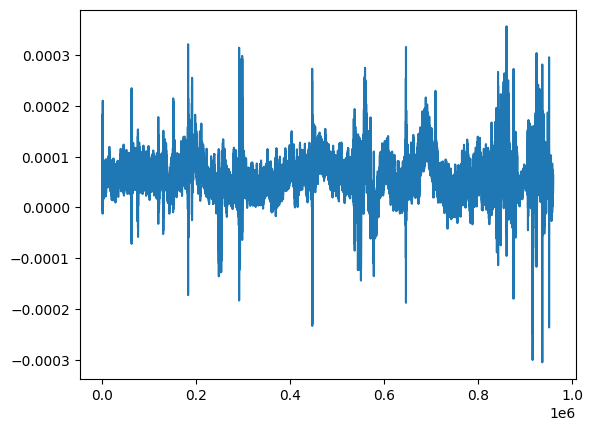

In [37]:
import matplotlib.pyplot as plt
plt.plot(raw[10,:][0].T)

In [38]:
# Step 1 Subtract 63 ms to account for EEG setup delay
raw.annotations.onset = raw.annotations.onset - 0.063

In [39]:
# Step 2 Re-sample the raw EEG data to 250 Hz
raw_resampled = raw.copy().resample(sfreq=250, npad="auto")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


/scratch/ipykernel_78895/3676571541.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=60)


Plotting power spectral density (dB=True).


/scratch/ipykernel_78895/3676571541.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered.plot_psd(fmax=60)


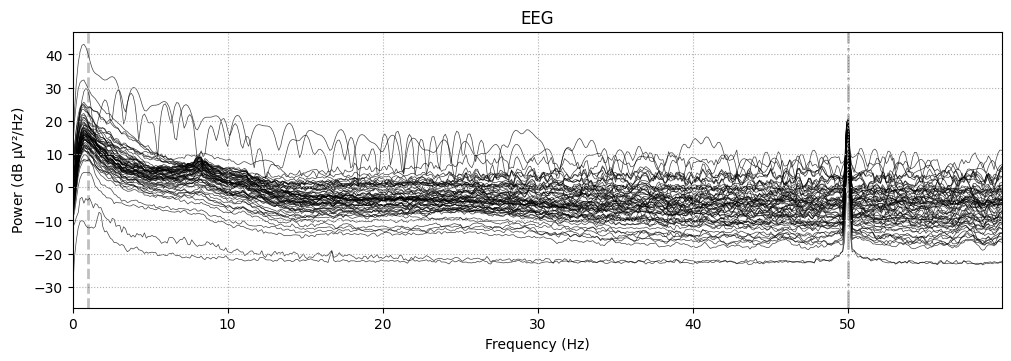

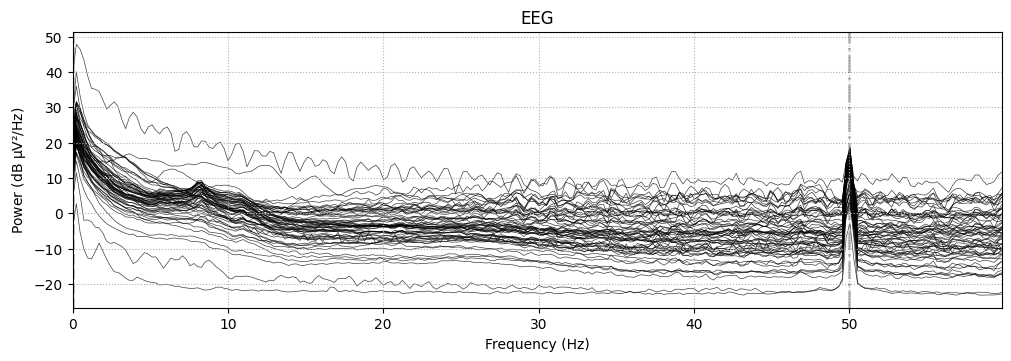

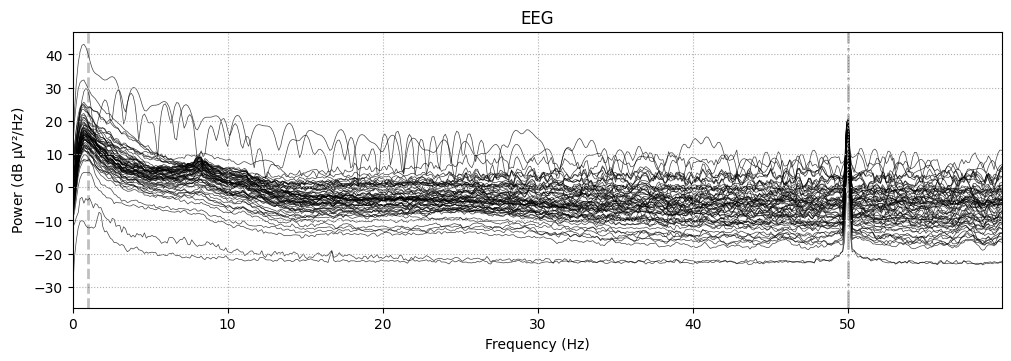

In [40]:
# Filtering 
# Step 3 High-pass filter at 1 Hz, low-pass filter at 125 Hz (at 124 cause of Nyquist)
filtered = raw_resampled.copy().filter(l_freq=1.0, h_freq=124.0)

# Plot the Power Spectral Density (PSD) before and after filtering
raw.plot_psd(fmax=60)  
filtered.plot_psd(fmax=60)  

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/scratch/ipykernel_78895/1471971579.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filtered.plot_psd(fmax=60)


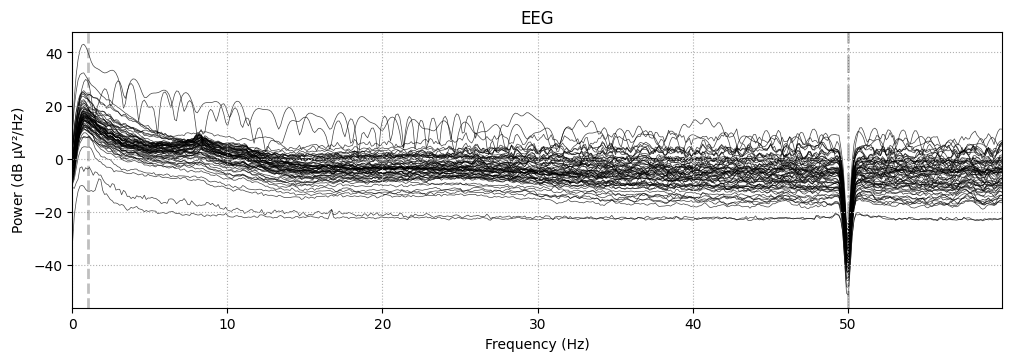

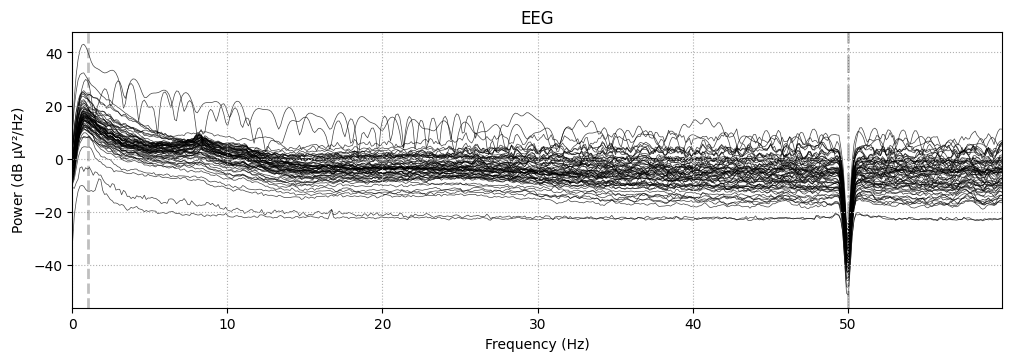

In [41]:
# Notch filter 50Hz to remove powerline artefact
raw_filtered = filtered.copy().notch_filter(freqs=50.0)
raw_filtered.plot_psd(fmax=60) 

Applying a custom ('EEG',) reference.


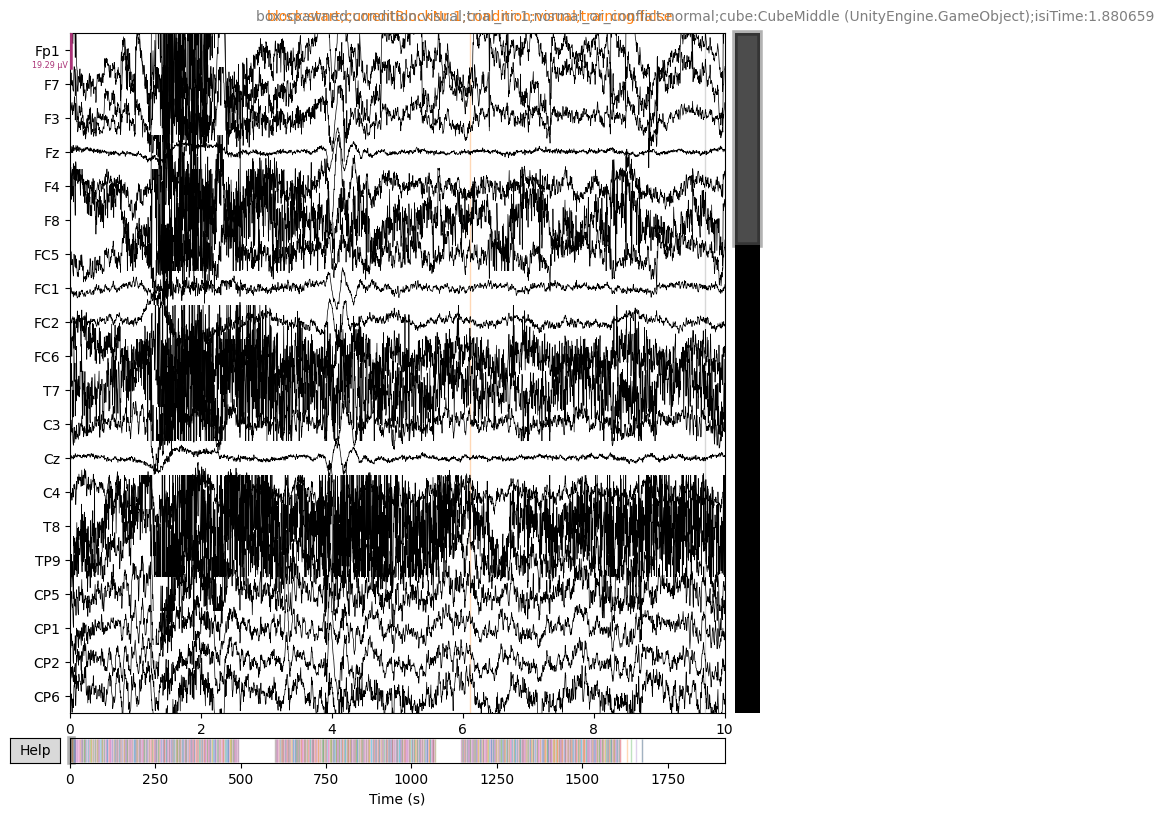

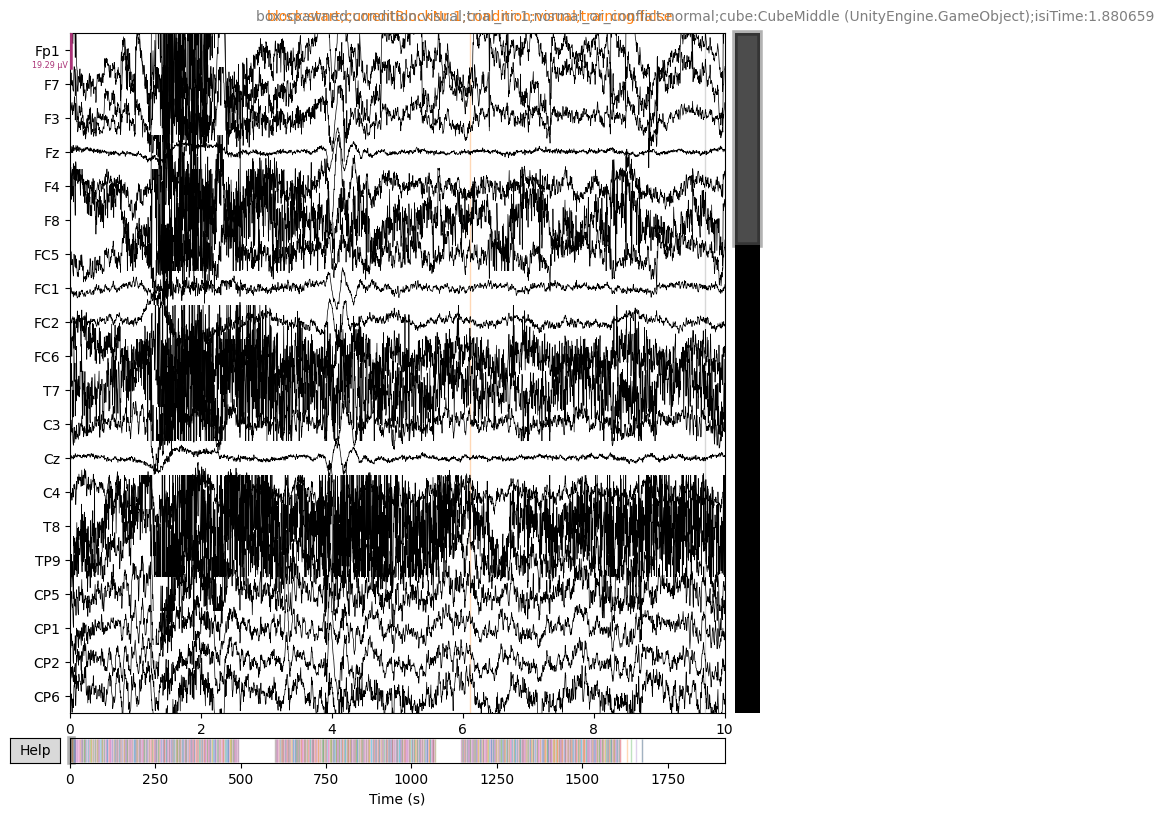

In [42]:
#Step 4 Re-referencing to the clusters of frontal electrodes(Fz, FC1, FC2 and Cz)
raw_referenced = raw_filtered.set_eeg_reference(ref_channels=['Fz', 'FC1', 'FC2', 'Cz'], ch_type='eeg')
raw_referenced.plot(n_channels=20, scalings='auto', show=True, block=True)

/scratch/ipykernel_78895/2948838951.py:2: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered.set_montage('standard_1020', match_case=False)


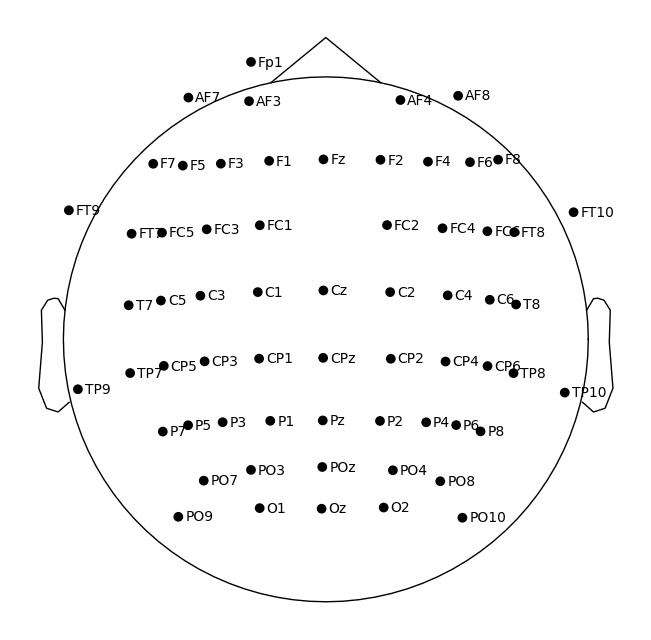

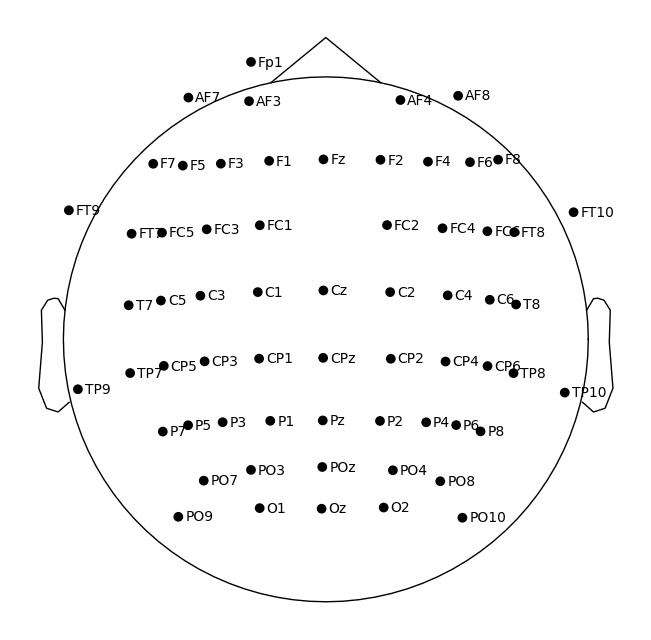

In [43]:
# Assign standard 10-20 montage and verify sensor positions
raw_filtered.set_montage('standard_1020', match_case=False)
raw_filtered.plot_sensors(kind='topomap', show_names=True)

Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:visual;training:false'), np.str_('block:start;currentBlockNr:1;condition:visual;training:false'), np.str_('block:start;currentBlockNr:2;condition:visual;training:false'), np.str_('block:start;currentBlockNr:3;condition:visual;training:false'), np.str_('box:spawned;condition:visual;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.777898'), np.str_('box:spawned;condition:visual;trial_nr:101;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.235522'), np.str_('box:spawned;condition:visual;trial_nr:102;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.278034'), np.str_('box:spawned;condition:visual;trial_nr:103;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.271817'), np.str_('box:spawned;condition:visual;trial_nr:104;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.4

/scratch/ipykernel_78895/1957730865.py:24: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 3.7s.


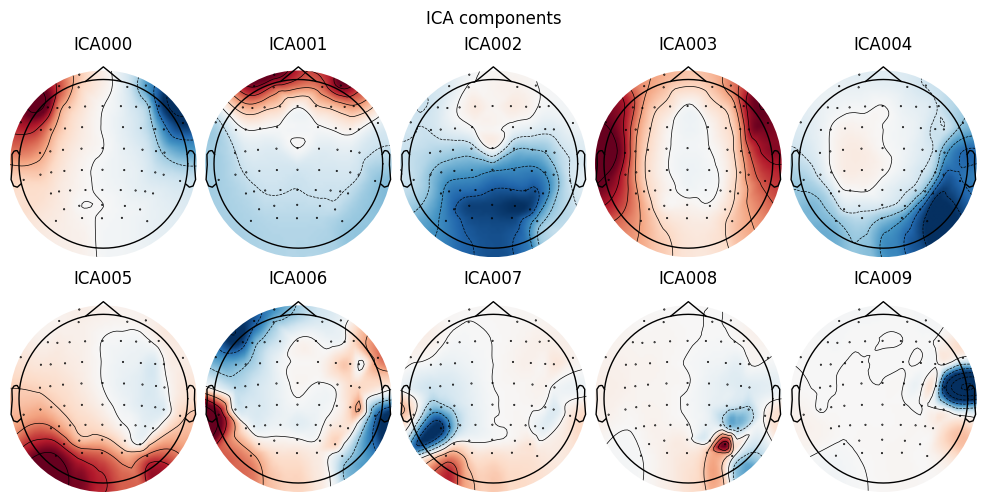

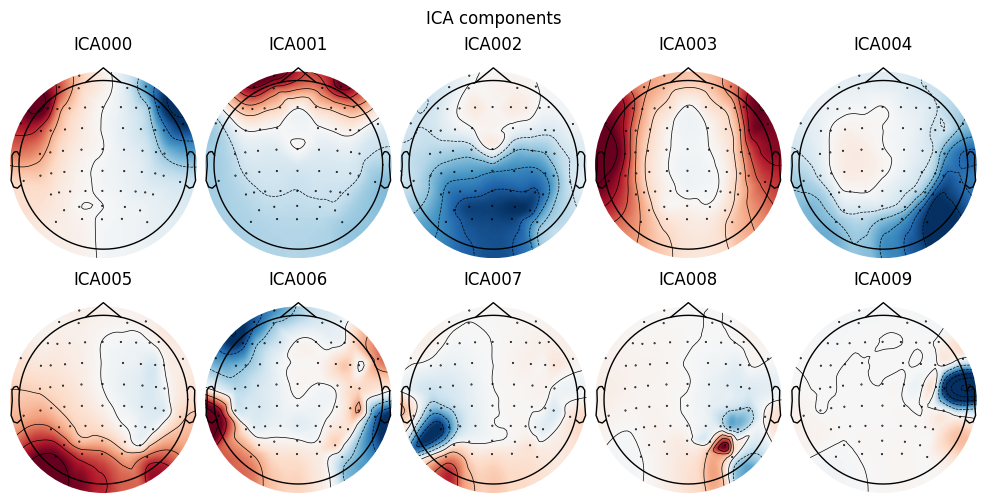

In [44]:
# Step 5
from mne.preprocessing import ICA
# Extract events and epochs
events, event_id = mne.events_from_annotations(raw_filtered)
epochs = mne.Epochs(raw_filtered, events, event_id, tmin=-0.3, tmax=0.7, 
                    preload=True, event_repeated="drop")

# Compute Mean Absolute Amplitude for Each Epoch
epoch_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
mean_amplitudes = np.mean(np.abs(epoch_data), axis=(1, 2))  # Mean over channels and time

# Rank Epochs by Mean Amplitude
ranked_indices = np.argsort(mean_amplitudes)  # Sort epochs from smallest to largest mean amplitude

# Keep 85% of the Cleanest Epochs
percentage = 85
n_epochs_to_keep = int(len(epochs) * (percentage / 100))
selected_indices = ranked_indices[:n_epochs_to_keep]  # Select top 85% clean epochs

# Create Clean Epochs and Apply ICA
clean_epochs = epochs[selected_indices]

ica = ICA(n_components=10, method='picard', random_state=42, max_iter=5000)
ica.fit(clean_epochs)

ica.plot_components()



In [45]:
# Step 6 Use ICLabel for automatic component classification
from mne_icalabel import label_components
labels = label_components(raw_filtered, ica, method='iclabel')

print("ICLabel Results:")
for idx, (label, prob) in enumerate(zip(labels['labels'], labels['y_pred_proba'])):
    print(f"Component {idx}: {label} (Probability: {prob:.2f})")

# Automatically mark bad components for exclusion
bad_ics = [idx for idx, label in enumerate(labels['labels'])
           if label in ('eye blink', 'muscle artifact', 'line_noise')]

ica.exclude = bad_ics  # Mark components for exclusion

ica.apply(raw_filtered)

raw_filtered.set_meas_date(None)

raw_filtered.save("cleaned_data_with_ICLabel_visual02.fif", overwrite=True)



/scratch/ipykernel_78895/3189468285.py:3: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_filtered, ica, method='iclabel')
/scratch/ipykernel_78895/3189468285.py:3: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_filtered, ica, method='iclabel')


ICLabel Results:
Component 0: eye blink (Probability: 1.00)
Component 1: eye blink (Probability: 1.00)
Component 2: brain (Probability: 1.00)
Component 3: brain (Probability: 0.85)
Component 4: brain (Probability: 0.89)
Component 5: brain (Probability: 0.89)
Component 6: line noise (Probability: 0.23)
Component 7: muscle artifact (Probability: 0.60)
Component 8: muscle artifact (Probability: 1.00)
Component 9: brain (Probability: 0.71)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 4 ICA components
    Projecting back using 63 PCA components
Writing /pfs/data5/home/st/st_us-053000/st_st190561/EEG/cleaned_data_with_ICLabel_visual02.fif


/scratch/ipykernel_78895/3189468285.py:19: RuntimeWarning: This filename (/pfs/data5/home/st/st_us-053000/st_st190561/EEG/cleaned_data_with_ICLabel_visual02.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save("cleaned_data_with_ICLabel_visual02.fif", overwrite=True)


Closing /pfs/data5/home/st/st_us-053000/st_st190561/EEG/cleaned_data_with_ICLabel_visual02.fif
[done]


In [46]:
events, event_id = mne.events_from_annotations(raw)

# Print the events
print("Extracted events:")
print(events)

# Print the event_id dictionary
print("Event IDs:")
print(event_id)

Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:visual;training:false'), np.str_('block:start;currentBlockNr:1;condition:visual;training:false'), np.str_('block:start;currentBlockNr:2;condition:visual;training:false'), np.str_('block:start;currentBlockNr:3;condition:visual;training:false'), np.str_('box:spawned;condition:visual;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.777898'), np.str_('box:spawned;condition:visual;trial_nr:101;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.235522'), np.str_('box:spawned;condition:visual;trial_nr:102;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.278034'), np.str_('box:spawned;condition:visual;trial_nr:103;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.271817'), np.str_('box:spawned;condition:visual;trial_nr:104;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.4

In [47]:
# Step 7: Filter ERP data with 0.2 Hz high-pass and 35 Hz low-pass
erp_filtered = raw_referenced.copy().filter(l_freq=0.2, h_freq=35.0)

# Step 8: Slice the data between -0.3 and 0.7 seconds around the stimulus onset
events, event_id = mne.events_from_annotations(erp_filtered)
epochs = mne.Epochs(erp_filtered, events, event_id=event_id, tmin=-0.3, tmax=0.7, event_repeated='drop',
                    baseline=(-0.3, 0), preload=True)

# Step 9: Reject 10% of the noisiest epochs based on signal amplitude
epoch_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
mean_amplitudes = np.mean(np.abs(epoch_data), axis=(1, 2))  # Compute mean amplitude for each epoch
threshold = np.percentile(mean_amplitudes, 90)  # Top 10% noisy epochs
clean_epochs = epochs[mean_amplitudes < threshold]

# Step 10: Focus analyses on selected electrodes (e.g., Fz, Cz)
frontal_channels = ['Fz', 'Cz']
clean_epochs.pick_channels(frontal_channels)

# Step 11: Extract ERP negativity peaks (minimum peak) in the 100–300 ms time window
time_window = (0.1, 0.3)  # 100–300 ms
negativity_peaks = {}

for ch_name in frontal_channels:
    channel_idx = clean_epochs.ch_names.index(ch_name)
    erp_data = clean_epochs.average().data[channel_idx]
    times = clean_epochs.times

    # Extract the data within the time window
    mask = (times >= time_window[0]) & (times <= time_window[1])
    time_window_data = erp_data[mask]
    time_window_times = times[mask]

    # Find the minimum (negative) peak
    peak_idx = np.argmin(time_window_data)
    peak_time = time_window_times[peak_idx]
    peak_amplitude = time_window_data[peak_idx]

    negativity_peaks[ch_name] = (peak_time, peak_amplitude)
    print(f"Channel {ch_name}: Negativity peak at {peak_time:.3f} s with amplitude {peak_amplitude:.3f} µV")




Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 4125 samples (16.500 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:visual;training:false'), np.str_('block:start;currentBlockNr:1;condition:visual;training:false'), np.str_('block:start;currentBlockNr:2;condition:visual;training:false'), np.str_('block:start;currentBlockNr:3;condition:visual;training:false'), np.str_('box:spawned;condition:visual;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.777898'), np.str_('box:spawned;condition:visual;trial_nr:101;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.235522'), np.str_('box:spawned;condition:visual;trial_nr:102;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.278034'), np.str_('box:spawned;condition:visual;trial_nr:103;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.271817'), np.str_('box:spawned;condition:visual;trial_nr:104;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.4

In [48]:
# Load filtered raw data
raw_referenced_visual = mne.io.read_raw_fif('cleaned_data_with_ICLabel_visual02.fif', preload=True)
raw_referenced_vibro = mne.io.read_raw_fif('cleaned_data_with_ICLabel_vibro02.fif', preload=True)
raw_referenced_ems = mne.io.read_raw_fif('cleaned_data_with_ICLabel_ems02.fif', preload=True)
# Extract events and annotations
events, event_id = mne.events_from_annotations(raw_filtered)

# Print all events and IDs
print("Available Events in Dataset:")
print(events)  # Event array (samples, 0, event_id)
print("Event IDs Map:")
print(event_id)


Opening raw data file cleaned_data_with_ICLabel_visual02.fif...
    Range : 0 ... 479545 =      0.000 ...  1918.180 secs
Ready.
Reading 0 ... 479545  =      0.000 ...  1918.180 secs...


/scratch/ipykernel_78895/310813905.py:2: RuntimeWarning: This filename (cleaned_data_with_ICLabel_visual02.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_referenced_visual = mne.io.read_raw_fif('cleaned_data_with_ICLabel_visual02.fif', preload=True)


Opening raw data file cleaned_data_with_ICLabel_vibro02.fif...
    Range : 0 ... 419385 =      0.000 ...  1677.540 secs
Ready.
Reading 0 ... 419385  =      0.000 ...  1677.540 secs...


/scratch/ipykernel_78895/310813905.py:3: RuntimeWarning: This filename (cleaned_data_with_ICLabel_vibro02.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_referenced_vibro = mne.io.read_raw_fif('cleaned_data_with_ICLabel_vibro02.fif', preload=True)


Opening raw data file cleaned_data_with_ICLabel_ems02.fif...
    Range : 0 ... 129016 =      0.000 ...   516.064 secs
Ready.
Reading 0 ... 129016  =      0.000 ...   516.064 secs...
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:visual;training:false'), np.str_('block:start;currentBlockNr:1;condition:visual;training:false'), np.str_('block:start;currentBlockNr:2;condition:visual;training:false'), np.str_('block:start;currentBlockNr:3;condition:visual;training:false'), np.str_('box:spawned;condition:visual;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.777898'), np.str_('box:spawned;condition:visual;trial_nr:101;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.235522'), np.str_('box:spawned;condition:visual;trial_nr:102;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.278034'), np.str_('box:spawned;condition:visual;trial_nr:103;normal_or_conflict:normal;cube:

/scratch/ipykernel_78895/310813905.py:4: RuntimeWarning: This filename (cleaned_data_with_ICLabel_ems02.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_referenced_ems = mne.io.read_raw_fif('cleaned_data_with_ICLabel_ems02.fif', preload=True)


In [49]:
# Step 1: Filter raw data
erp_filtered_ems = raw_referenced_ems.copy().filter(l_freq=0.2, h_freq=35.0)
print("ERP data filtered with 0.2–35 Hz bandpass.")
erp_filtered_vibro = raw_referenced_vibro.copy().filter(l_freq=0.2, h_freq=35.0)
erp_filtered_visual = raw_referenced_visual.copy().filter(l_freq=0.2, h_freq=35.0)

print(erp_filtered.annotations.description)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 4125 samples (16.500 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


ERP data filtered with 0.2–35 Hz bandpass.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 4125 samples (16.500 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 4125 samples (16.500 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


['block:start;currentBlockNr:1;condition:visual;training:false'
 'box:spawned;condition:visual;trial_nr:1;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.880659'
 'box:touched;condition:visual;reaction_time:1.050021;trial_nr:1;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.880659'
 'visualFeedback:off'
 'box:spawned;condition:visual;trial_nr:2;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.25513'
 'box:touched;condition:visual;reaction_time:0.8605666;trial_nr:2;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.25513'
 'visualFeedback:off'
 'box:spawned;condition:visual;trial_nr:3;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.638804'
 'box:touched;condition:visual;reaction_time:0.8151078;trial_nr:3;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.638804'
 'visualFeedback:off'
 'box:spawned;condition:visual;trial_nr:4

Used Annotations descriptions: [np.str_('block:end;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.674886'), np.str_('box:spawned;condition:vibro;trial_nr:10;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.224597'), np.str_('box:spawned;condition:vibro;trial_nr:11;normal_or_conflict:conflict;cube:CubeRight (UnityEngine.GameObject);isiTime:1.552389'), np.str_('box:spawned;condition:vibro;trial_nr:12;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.997462'), np.str_('box:spawned;condition:vibro;trial_nr:13;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.716086'), np.str_('box:spawned;condition:vibro;trial_nr:14;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.209728'), np.str_('b

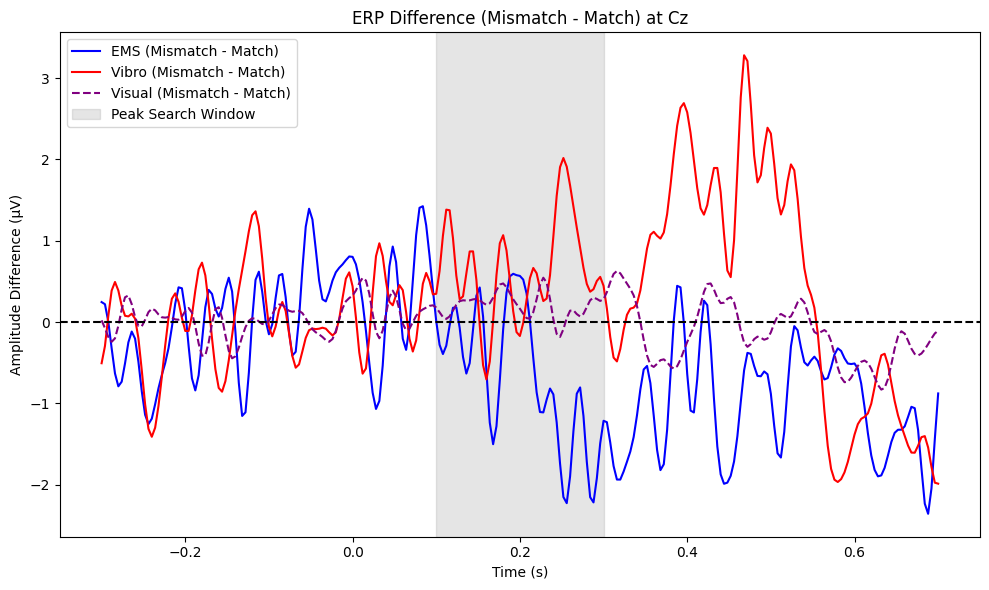

In [50]:
# Step 2: Event mapping for matches and mismatches
event_id = {
    'box:spawned': 3,       # Match condition
    'box:touched': 4,       # Match condition
    'duplicate_event': 5,   # Mismatch: EMS
    'vibroFeedback:off': 10,  # Mismatch: Vibro
    'visualFeedback:off': 11  # Mismatch: Visual
}
events_ems, _ = mne.events_from_annotations(erp_filtered_ems)
events_vibro, _ = mne.events_from_annotations(erp_filtered_vibro)
events_visual, _ = mne.events_from_annotations(erp_filtered_visual)


# Step 3: Extract events and slice the data into epochs

epochs_mismatch_ems = mne.Epochs(
    erp_filtered_ems, events_ems, event_id={'duplicate_event': 5}, tmin=-0.3, tmax=0.7,
    baseline=(-0.3, 0), preload=True, event_repeated='drop'
)

epochs_mismatch_vibro = mne.Epochs(
    erp_filtered_vibro, events_vibro, event_id={'vibroFeedback:off': 10}, tmin=-0.3, tmax=0.7,
    baseline=(-0.3, 0), preload=True, event_repeated='drop'
)

epochs_mismatch_visual = mne.Epochs(
    erp_filtered_visual, events_visual, event_id={'box:spawned': 3, 'box:touched': 4,'duplicate_event': 5}, tmin=-0.3, tmax=0.7,
    baseline=(-0.3, 0), preload=True, event_repeated='drop'
)

epochs_match_ems = mne.Epochs(
    erp_filtered_ems, events_ems, event_id={'box:spawned': 3, 'box:touched': 4}, tmin=-0.3, tmax=0.7,
    baseline=(-0.3, 0), preload=True, event_repeated='drop'
)

epochs_match_vibro = mne.Epochs(
    erp_filtered_vibro, events_vibro, event_id={'box:spawned': 3, 'box:touched': 4}, tmin=-0.3, tmax=0.7,
    baseline=(-0.3, 0), preload=True, event_repeated='drop'
)

epochs_match_visual = mne.Epochs(
    erp_filtered_visual, events_visual, event_id={'box:spawned': 3, 'box:touched': 4}, tmin=-0.3, tmax=0.7,
    baseline=(-0.3, 0), preload=True, event_repeated='drop'
)


channel = 'Fz'


# Average ERP for each mismatch condition
erp_mismatch_ems = epochs_mismatch_ems.average().pick(channel).data.flatten()
erp_mismatch_vibro = epochs_mismatch_vibro.average().pick(channel).data.flatten()
erp_mismatch_visual = epochs_mismatch_visual.average().pick(channel).data.flatten()

# Average ERP for each match condition
erp_match_ems = epochs_match_ems.average().pick(channel).data.flatten()
erp_match_vibro = epochs_match_vibro.average().pick(channel).data.flatten()
erp_match_visual = epochs_match_visual.average().pick(channel).data.flatten()

# Calculate the difference between mismatch and match conditions
diff_ems = erp_mismatch_ems - erp_match_ems
diff_vibro = erp_mismatch_vibro - erp_match_vibro
diff_visual = erp_mismatch_visual - erp_match_visual

# Time vector
times = epochs_match_ems.times

# Plotting the differences
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the difference for EMS
ax.plot(times, diff_ems * 1e6, label='EMS (Mismatch - Match)', color='blue')

# Plot the difference for Vibro
ax.plot(times, diff_vibro * 1e6, label='Vibro (Mismatch - Match)', color='red')

# Plot the difference for Visual
ax.plot(times, diff_visual * 1e6, label='Visual (Mismatch - Match)', color='purple', linestyle='--')

# Highlight the 100–300 ms window for negativity peaks
ax.axvspan(0.1, 0.3, color='gray', alpha=0.2, label='Peak Search Window')

# Customize the plot
ax.axhline(0, color='black', linestyle='--')
ax.set_title("ERP Difference (Mismatch - Match) at Cz")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude Difference (µV)")
ax.legend()
plt.tight_layout()
plt.show()
